# Imports

In [1]:
import torch 
import torch.nn as nn
# Optimization --> Adam, SGD 
import torch.optim as optim
# Functional --> Conv functions, Linear functions, Non-LinearFunctions (Activation functions)
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
# Getting dataset
import torchvision.datasets as datasets
# Transform dataset
import torchvision.transforms as transforms

# Create Fully Connected Network

In [2]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes): # (28*28 pixal image)
    super(NN, self).__init__()  # Calls the initialization method of the parent class (nn.module)
    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, num_classes)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Set device

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters

In [5]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_eppochs = 7

# Load Data

In [6]:
train_dataset = datasets.MNIST(root = 'dataset/', train = True, transform = transforms.ToTensor(), download = True)
train_dataset, valid_dataset = random_split(train_dataset, [0.75,0.25])
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle = True)

In [7]:
test_dataset = datasets.MNIST(root = 'dataset/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

In [8]:
train_dataset

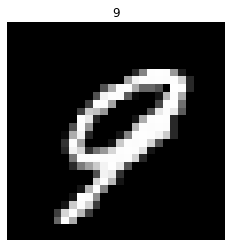

In [9]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
plt.title(f'{label}')
plt.axis("off")
plt.imshow(img.squeeze(), cmap ='gray')
plt.show()

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/
    Split: Test
    StandardTransform
Transform: ToTensor()

# Initialize network

In [11]:
model = NN(input_size = input_size, num_classes = num_classes).to(device)

# Loss and optimizer


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train Network

___

In [13]:
dataiter = iter(train_loader)
inputs, labels = next(dataiter)

In [14]:
inputs.shape

torch.Size([64, 1, 28, 28])

In [15]:
labels.shape

torch.Size([64])

### 64 examples in a single batch.

### Contains single band 28*28 pixels image

In [16]:
inputs.reshape(inputs.shape[0], -1).shape

torch.Size([64, 784])

Changing the 64, 1, 28, 28 shape of array to Single array of 64 examples. (Much like flatenning the array as used in TF)
___

In [17]:
from tqdm.notebook import tqdm

In [18]:
train_hist = []
valid_hist = []
for epoch in range(num_eppochs):
  running_tloss = 0.0
  running_vloss = 0.0
  for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device = device) # tensor to data that is used by cuda
    targets = targets.to(device = device)

    # Get to correct shape
    data = data.reshape(data.shape[0], -1)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()
    running_tloss += loss.item()

  train_hist.append(running_tloss)
  for data, labels in valid_loader:
    data = data.to(device = device) # tensor to data that is used by cuda
    labels = labels.to(device = device)
    data = data.reshape(data.shape[0], -1)

    # forward
    scores = model(data)
    loss = criterion(scores, labels)

    running_vloss += loss.item()
  valid_hist.append(running_vloss)
  # display statistics
  print(f'[{epoch + 1}, {batch_idx + 1:5d}] t_loss: {running_tloss:.5f} v_loss: {running_vloss:.5f}') 

  0%|          | 0/704 [00:00<?, ?it/s]

[1,   704] t_loss: 230.46938 v_loss: 38.62220


  0%|          | 0/704 [00:00<?, ?it/s]

[2,   704] t_loss: 88.61711 v_loss: 29.16901


  0%|          | 0/704 [00:00<?, ?it/s]

[3,   704] t_loss: 57.83307 v_loss: 23.63730


  0%|          | 0/704 [00:00<?, ?it/s]

[4,   704] t_loss: 41.48617 v_loss: 21.89399


  0%|          | 0/704 [00:00<?, ?it/s]

[5,   704] t_loss: 31.44364 v_loss: 26.96703


  0%|          | 0/704 [00:00<?, ?it/s]

[6,   704] t_loss: 24.93556 v_loss: 21.61059


  0%|          | 0/704 [00:00<?, ?it/s]

[7,   704] t_loss: 18.55379 v_loss: 19.23352


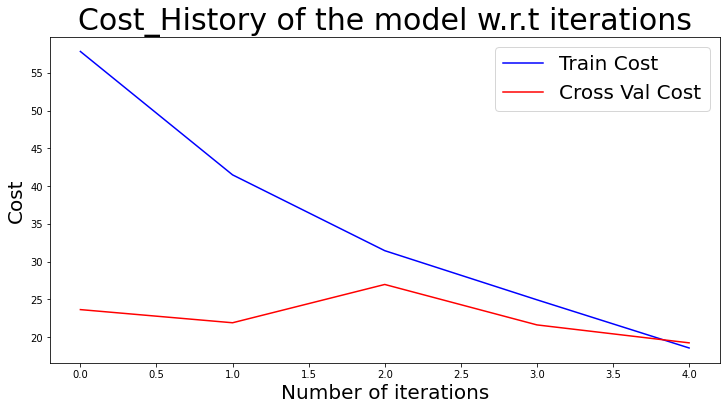

In [19]:
fig, ax = plt.subplots(figsize = (12,6))
ax = plt.plot(train_hist[2:], color = 'Blue')
ax = plt.plot(valid_hist[2:], color = 'red')
plt.title('Cost_History of the model w.r.t iterations', fontsize = 30)
plt.xlabel('Number of iterations', fontsize = 20)
plt.ylabel('Cost', fontsize = 20)
plt.legend(['Train Cost', 'Cross Val Cost'], fontsize = 20)
plt.show()

# Check accuracy on training & test to see how good our model is

model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time.

For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:

In [20]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device = device)
      y = y.to(device = device)
      x = x.reshape(x.shape[0],-1)

      scores = model(x)
      __, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)
    acc = float(num_correct)/float(num_samples)*100
    print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
  model.train()
  return acc

In [22]:
check_accuracy(train_loader, model)
check_accuracy(valid_loader, model)
check_accuracy(test_loader, model)

Got 44805 / 45000 with accuracy 99.57
Got 14684 / 15000 with accuracy 97.89
Got 9776 / 10000 with accuracy 97.76


97.76